# Exploring WildChat-1M Dataset

## Learning Objectives
By the end of this notebook, you will understand:
- How to load and explore large conversational datasets
- Techniques for data analysis and visualization with pandas and matplotlib
- Topic modeling methods using BERTopic
- Dimensionality reduction and visualization with t-SNE
- How to extract insights from conversational AI data

## Introduction
This notebook explores the WildChat-1M dataset - a large collection of real conversations between users and AI assistants. We'll analyze conversation patterns, discover topics in user requests, and visualize the results to understand what types of questions and requests people commonly make to AI systems.

**Why is this important?** Understanding user behavior with AI systems helps us:
- Build better RAG (Retrieval-Augmented Generation) systems
- Identify common use cases and patterns
- Improve AI assistant performance
- Design more effective user interfaces


In [1]:
import pandas as pd
from datasets import load_dataset
import random
import matplotlib.pyplot as plt
import seaborn as sns

# Set style for better-looking plots
plt.style.use('default')
sns.set_palette("husl")


## Part 1: Setting Up Our Analysis Environment

### Key Libraries We're Using:
- **`pandas`**: For data manipulation and analysis
- **`datasets`**: Hugging Face library for loading the WildChat dataset
- **`matplotlib/seaborn`**: For creating visualizations
- **`random`**: For sampling data

### What You'll Learn Here:
- How to set up a data science environment
- Best practices for importing libraries
- Setting up visualization styles for consistent, professional plots


In [2]:
# Alternative: Even faster approach for very large datasets
# This approach can be parallelized and is memory efficient

def process_batch_efficiently(batch_data):
    """Process a batch of samples efficiently"""
    conversations = batch_data['conversation']
    
    # Vectorized operations where possible
    conversation_lengths = [len(conv) for conv in conversations]
    first_message_lengths = [
        len(conv[0].get('content', '')) if conv and len(conv) > 0 else 0
        for conv in conversations
    ]
    
    return {
        'conversation_length': conversation_lengths,
        'language': batch_data['language'],
        'model': batch_data['model'],
        'toxic': batch_data['toxic'],
        'redacted': batch_data['redacted'],
        'first_message_length': first_message_lengths
    }

# This approach would be even faster for very large datasets:
# 1. Process in batches to reduce memory usage
# 2. Use multiprocessing for parallel processing
# 3. Use numpy arrays for numerical operations

print("For datasets larger than a few hundred thousand samples, consider:")
print("1. Processing in batches")
print("2. Using multiprocessing/threading")
print("3. Using Apache Arrow format for faster I/O")
print("4. Using pandas' built-in optimization features")


For datasets larger than a few hundred thousand samples, consider:
1. Processing in batches
2. Using multiprocessing/threading
3. Using Apache Arrow format for faster I/O
4. Using pandas' built-in optimization features


## Part 2: Loading and Preparing the Dataset

### What is WildChat-1M?
WildChat-1M is a dataset containing real conversations between users and ChatGPT models. It includes:
- **1 million conversations** from real users
- **Multiple languages** (69 different languages)
- **Different AI models** (GPT-3.5 and GPT-4)
- **Conversation metadata** (language, toxicity flags, etc.)

### Key Concepts You'll Learn:
- **Dataset Loading**: Using Hugging Face `datasets` library for large datasets
- **Data Sampling**: Working with subsets of large datasets for faster processing
- **Memory Management**: Optimizing data loading for large datasets
- **Data Structure Understanding**: How conversational data is organized

### Why Sample the Data?
We're loading 100,000 samples instead of the full million because:
- Faster processing for educational purposes
- Sufficient for understanding patterns
- Reduces memory requirements


In [3]:
# Load a larger sample of the WildChat-1M dataset for meaningful distributions
print("Loading WildChat-1M dataset...")
dataset = load_dataset("allenai/WildChat-1M", split="train[:10000]")
print(f"Dataset loaded! Total samples: {len(dataset)}")

# Set random seed for reproducibility
random.seed(42)

# Convert to pandas DataFrame for easier analysis - OPTIMIZED VERSION
print("Converting to DataFrame...")

# Method 1: Use the built-in to_pandas() method (fastest for most cases)
try:
    # Convert the dataset directly to pandas
    base_df = dataset.to_pandas()
    
    # Add computed columns efficiently using vectorized operations
    df = base_df.copy()
    df['conversation_length'] = df['conversation'].apply(len)
    # Fix the ambiguous truth value error by using a proper function
    def get_first_message_length(conv):
        if isinstance(conv, list) and len(conv) > 0:
            return len(conv[0].get('content', ''))
        return 0
    
    df['first_message_length'] = df['conversation'].apply(get_first_message_length)
    
    # Keep only the columns we need
    df = df[['conversation_length', 'language', 'model', 'toxic', 'redacted', 'first_message_length']]
    print("Direct conversion successful!")
    
except Exception as e:
    print(f"Direct conversion failed: {e}")
    print("Falling back to optimized manual conversion...")
    
    # Method 2: Optimized manual conversion using list comprehension
    df_data = [
        {
            'conversation_length': len(sample.get('conversation', [])),
            'language': sample.get('language', 'unknown'),
            'model': sample.get('model', 'unknown'),
            'toxic': sample.get('toxic', False),
            'redacted': sample.get('redacted', False),
            'first_message_length': (
                len(sample['conversation'][0].get('content', '')) 
                if sample.get('conversation') and len(sample['conversation']) > 0 
                else 0
            )
        }
        for sample in dataset
    ]
    
    # Use from_records for faster DataFrame creation
    df = pd.DataFrame.from_records(df_data)

print(f"DataFrame created with {len(df)} samples")
print(f"Columns: {list(df.columns)}")


Loading WildChat-1M dataset...
Dataset loaded! Total samples: 10000
Converting to DataFrame...
Direct conversion successful!
DataFrame created with 10000 samples
Columns: ['conversation_length', 'language', 'model', 'toxic', 'redacted', 'first_message_length']


In [4]:
# Display basic statistics
print("Dataset Overview:")
print("=" * 50)
print(f"Total samples: {len(df)}")
print(f"Unique languages: {df['language'].nunique()}")
print(f"Unique models: {df['model'].nunique()}")
print(f"Toxic conversations: {df['toxic'].sum()} ({df['toxic'].mean():.2%})")
print(f"Redacted conversations: {df['redacted'].sum()} ({df['redacted'].mean():.2%})")
print()

# Show basic info about the dataframe
print("DataFrame Info:")
print(df.info())
print()
print("Sample of the data:")
print(df.head())


Dataset Overview:
Total samples: 10000
Unique languages: 62
Unique models: 2
Toxic conversations: 0 (0.00%)
Redacted conversations: 77 (0.77%)

DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 6 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   conversation_length   10000 non-null  int64 
 1   language              10000 non-null  object
 2   model                 10000 non-null  object
 3   toxic                 10000 non-null  bool  
 4   redacted              10000 non-null  bool  
 5   first_message_length  10000 non-null  int64 
dtypes: bool(2), int64(2), object(2)
memory usage: 332.2+ KB
None

Sample of the data:
   conversation_length language       model  toxic  redacted  \
0                    2  English  gpt-4-0314  False     False   
1                    4  Spanish  gpt-4-0314  False     False   
2                    2  English  gpt-4-0314  False    

## Part 3: Exploratory Data Analysis (EDA)

### What is EDA and Why is it Important?
Exploratory Data Analysis is the critical first step in any data science project. It helps us:
- Understand the structure and characteristics of our data
- Identify patterns, trends, and anomalies
- Make informed decisions about further analysis
- Communicate findings through visualizations

### Visualization Techniques We'll Use:
- **Histograms**: Show distribution of numerical data (conversation lengths, message lengths)
- **Bar Charts**: Display categorical data (languages, models)
- **Log Scales**: Handle data with wide ranges (some conversations are very short, others very long)

### Why Use Log Scales?
Log scales are essential when data spans several orders of magnitude:
- **Normal scale**: Hard to see patterns when data ranges from 2 to 118 messages
- **Log scale**: Reveals patterns across the entire range
- **Best practice**: Always consider log scales for count data and lengths


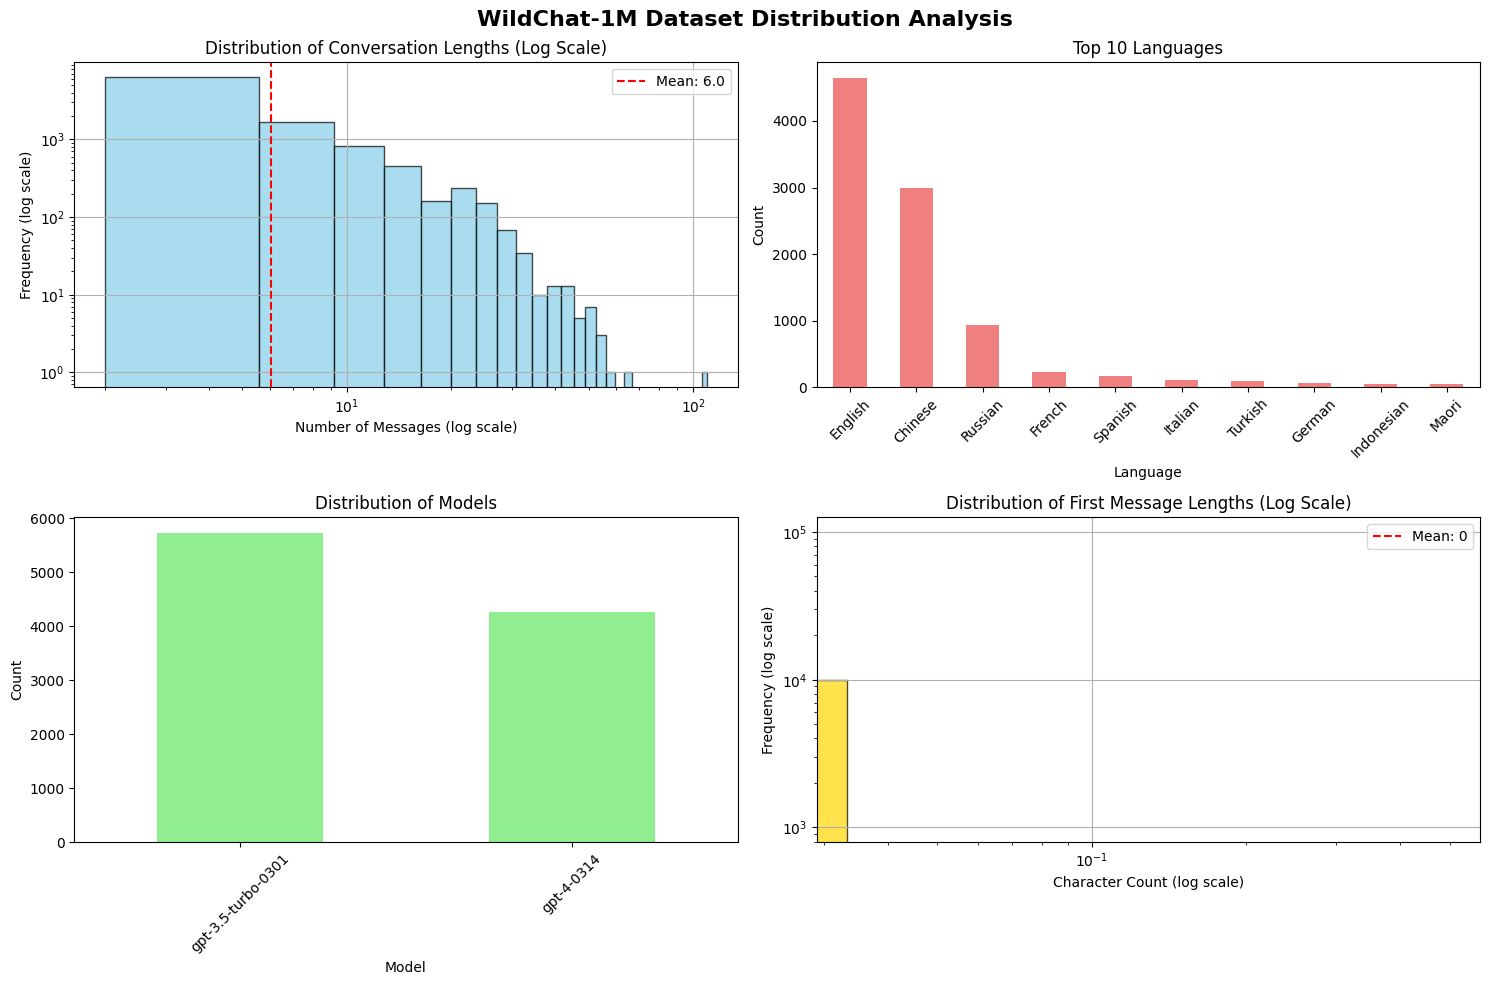

In [5]:
# Create comprehensive distribution plots
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('WildChat-1M Dataset Distribution Analysis', fontsize=16, fontweight='bold')

# 1. Conversation Length Distribution
ax1 = axes[0, 0]
df['conversation_length'].hist(bins=30, ax=ax1, alpha=0.7, color='skyblue', edgecolor='black')
ax1.set_title('Distribution of Conversation Lengths (Log Scale)')
ax1.set_xlabel('Number of Messages (log scale)')
ax1.set_ylabel('Frequency (log scale)')
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.axvline(df['conversation_length'].mean(), color='red', linestyle='--', 
           label=f'Mean: {df["conversation_length"].mean():.1f}')
ax1.legend()

# 2. Language Distribution (Top 10)
ax2 = axes[0, 1]
top_languages = df['language'].value_counts().head(10)
top_languages.plot(kind='bar', ax=ax2, color='lightcoral')
ax2.set_title('Top 10 Languages')
ax2.set_xlabel('Language')
ax2.set_ylabel('Count')
ax2.tick_params(axis='x', rotation=45)

# 3. Model Distribution
ax3 = axes[1, 0]
model_counts = df['model'].value_counts()
if len(model_counts) > 8:  # If too many models, show top 8
    model_counts = model_counts.head(8)
model_counts.plot(kind='bar', ax=ax3, color='lightgreen')
ax3.set_title('Distribution of Models')
ax3.set_xlabel('Model')
ax3.set_ylabel('Count')
ax3.tick_params(axis='x', rotation=45)

# 4. First Message Length Distribution
ax4 = axes[1, 1]
df['first_message_length'].hist(bins=30, ax=ax4, alpha=0.7, color='gold', edgecolor='black')
ax4.set_title('Distribution of First Message Lengths (Log Scale)')
ax4.set_xlabel('Character Count (log scale)')
ax4.set_ylabel('Frequency (log scale)')
ax4.set_xscale('log')
ax4.set_yscale('log')
ax4.axvline(df['first_message_length'].mean(), color='red', linestyle='--', 
           label=f'Mean: {df["first_message_length"].mean():.0f}')
ax4.legend()

plt.tight_layout()
plt.show()


# Part 4: Exploring Our Inventory - Topic Modeling Analysis

## What is Topic Modeling?
Topic modeling is an **unsupervised machine learning** technique that discovers abstract topics within a collection of documents. It's like having an intelligent librarian automatically categorize books by their content themes.

### Why Model Topics in User Messages?
Understanding user intent is crucial for building better AI systems:
- **Identify common patterns** in user requests
- **Discover different use cases** for AI assistants  
- **Improve RAG systems** by understanding query types
- **Design better user experiences** based on actual usage

### The Machine Learning Pipeline We'll Build:
1. **Text Preprocessing**: Clean and prepare user messages
2. **Topic Discovery**: Use BERTopic to automatically find topics
3. **Topic Analysis**: Examine keywords and representative documents
4. **Visualization**: Use t-SNE to visualize topics in 2D space
5. **Interpretation**: Understand what each topic represents

### Key Concepts You'll Master:
- **BERTopic**: State-of-the-art topic modeling using transformers
- **HDBSCAN Clustering**: Density-based clustering for finding topics
- **t-SNE**: Technique to visualize high-dimensional data in 2D
- **Topic Coherence**: How to evaluate topic quality


### Step 1: Text Extraction and Preprocessing

**What we're doing here:**
1. **Extract first messages**: The initial user request is most important for understanding intent
2. **Filter by length**: Remove very short messages (likely not meaningful)
3. **Focus on English**: Better topic modeling results with consistent language
4. **Sample strategically**: Balance between speed and representative results

**Why focus on first messages?**
- **User intent**: First message reveals what the user actually wants
- **Query patterns**: Helps us understand how people naturally ask questions
- **RAG applications**: Most relevant for improving search and retrieval systems

**Data preprocessing best practices:**
- Always inspect your data before processing
- Filter out noise (very short/empty messages)
- Consider language-specific processing
- Sample intelligently to maintain data quality


In [6]:
# Extract first messages from conversations
print("Extracting first messages from conversations...")

# Get the actual conversation content from the dataset
first_messages = []
languages = []
models = []

for i, sample in enumerate(dataset):
    conversation = sample.get('conversation', [])
    if conversation and len(conversation) > 0:
        first_message = conversation[0].get('content', '')
        # Filter out very short messages (likely not meaningful)
        if len(first_message.strip()) > 10:
            first_messages.append(first_message.strip())
            languages.append(sample.get('language', 'unknown'))
            models.append(sample.get('model', 'unknown'))

print(f"Extracted {len(first_messages)} first messages")
print(f"Sample message: {first_messages[0][:200]}...")

# Focus on English messages for better topic modeling results
english_indices = [i for i, lang in enumerate(languages) if lang == 'English']
english_messages = [first_messages[i] for i in english_indices]
english_models = [models[i] for i in english_indices]

print(f"Focusing on {len(english_messages)} English messages for topic modeling")


Extracting first messages from conversations...
Extracted 8814 first messages
Sample message: Hey there! Are you familiar with reality shifting? So, I’m refining a foolproof method for reality shifting and want to pick a destination. Want to help me? I’m thinking something pretty personalized....
Focusing on 4473 English messages for topic modeling


### Step 2: Topic Modeling with BERTopic

**What is BERTopic?**
BERTopic is a state-of-the-art topic modeling technique that leverages transformer-based embeddings to discover topics in text data. Unlike traditional methods, it:
- **Uses contextual embeddings**: Captures semantic meaning better than word-based approaches
- **Automatically determines topics**: No need to specify number of topics in advance
- **Provides interpretable results**: Clear topic keywords and representative documents
- **Handles outliers**: Identifies noise and assigns it to an outlier topic

**How BERTopic Works:**
1. **Create embeddings**: Convert text to high-dimensional vectors using sentence transformers
2. **Reduce dimensionality**: Use UMAP to reduce embedding dimensions while preserving structure
3. **Cluster documents**: Apply HDBSCAN to find dense regions (topics)
4. **Extract topics**: Use TF-IDF variants to identify representative words for each topic
5. **Fine-tune**: Optionally improve topic coherence with additional techniques

**Why BERTopic for User Message Analysis?**
- **Discovers natural topics**: Automatically finds meaningful themes in user requests
- **Handles diverse content**: Works well with varied question types and lengths
- **Provides rich insights**: Keywords, representative documents, and topic relationships
- **Scales well**: Efficient processing of large message collections


In [7]:
from bertopic import BERTopic

print(f"Performing topic modeling on {len(english_messages)} messages...")

# Take a sample for faster processing (adjust size as needed)
sample_size = min(1000, len(english_messages))
sample_messages = english_messages[:sample_size]
sample_models = english_models[:sample_size]

# Initialize BERTopic with string model name (simpler approach)
topic_model = BERTopic(
    embedding_model="all-MiniLM-L6-v2",
    language="english",
    calculate_probabilities=True,
    min_topic_size=10,
    verbose=True
)

# Fit the model and get topic assignments
topics, probs = topic_model.fit_transform(sample_messages)

# Get basic information about discovered topics
topic_info = topic_model.get_topic_info()
n_topics = len(topic_info) - 1  # Subtract 1 for outlier topic (-1)

print(f"Topic modeling complete!")
print(f"Found {n_topics} topics (plus outliers)")
print(f"Total documents: {len(sample_messages)}")
print(f"Outlier documents: {sum(1 for t in topics if t == -1)}")

# Display topic overview
print("\nTopic Overview:")
print(topic_info.head(10))

2025-06-29 17:56:19,064 - BERTopic - Embedding - Transforming documents to embeddings.


Performing topic modeling on 4473 messages...


Batches:   0%|          | 0/32 [00:00<?, ?it/s]

2025-06-29 17:56:23,042 - BERTopic - Embedding - Completed ✓
2025-06-29 17:56:23,042 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-06-29 17:56:26,389 - BERTopic - Dimensionality - Completed ✓
2025-06-29 17:56:26,390 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-06-29 17:56:26,460 - BERTopic - Cluster - Completed ✓
2025-06-29 17:56:26,462 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-06-29 17:56:26,542 - BERTopic - Representation - Completed ✓


Topic modeling complete!
Found 31 topics (plus outliers)
Total documents: 1000
Outlier documents: 285

Topic Overview:
   Topic  Count                                  Name  \
0     -1    285                     -1_you_the_and_to   
1      0     48          0_hardrules_you_chatgpt_mode   
2      1     46            1_his_justin_he_characters   
3      2     42                     2_r0_printf_r1_r4   
4      3     37           3_disks_disk_available_pool   
5      4     36         4_data_supply_analytics_chain   
6      5     31                      5_we_our_and_for   
7      6     30                      6_her_the_and_of   
8      7     30                   7_args_file_key_gpt   
9      8     28  8_morocco_travel_avoidance_humanlike   

                                      Representation  \
0    [you, the, and, to, of, in, that, jane, it, is]   
1  [hardrules, you, chatgpt, mode, developer, it,...   
2  [his, justin, he, characters, him, and, hunter...   
3  [r0, printf, r1, r4, int, 